# Object Detection using SIFT in OpenCV

This notebook demonstrates how to use the Scale-Invariant Feature Transform (SIFT) algorithm to detect and match objects between two images. We will upload a query image (the object we want to find) and a target image (where we want to find the object), and then use SIFT to locate the object in the target image.



##Import Libraries and Upload Images

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

In [49]:
print("Please upload the query image (the object you want to find):")
query_file = files.upload()
query_filename = list(query_file.keys())[0]

print("Please upload the target image (where you want to find the object):")
target_file = files.upload()
target_filename = list(target_file.keys())[0]

# Load images in color
query_img_color = cv2.imread(query_filename)
target_img_color = cv2.imread(target_filename)

# Create grayscale versions for feature detection
query_img = cv2.cvtColor(query_img_color, cv2.COLOR_BGR2GRAY)
target_img = cv2.cvtColor(target_img_color, cv2.COLOR_BGR2GRAY)

Please upload the query image (the object you want to find):


Saving Screenshot 2025-04-19 202621.png to Screenshot 2025-04-19 202621.png
Please upload the target image (where you want to find the object):


Saving target.png to target (1).png


**Explanation:**  
In this step, we import the necessary libraries and provide a mechanism to upload two images: a query image and a target image. The images are loaded in both color and grayscale formats, as SIFT operates on grayscale images.

##Define the Object Detection Function

In [50]:
# Cell 3: Object detection with SIFT - keep your existing function
def detect_object(query_img, target_img, draw_box=True, ratio_thresh=0.7, ransac_thresh=3.0):
    # Initialize SIFT detector and find keypoints/descriptors
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(query_img, None)
    kp2, des2 = sift.detectAndCompute(target_img, None)

    # FLANN matching
    FLANN_INDEX_KDTREE = 1
    flann = cv2.FlannBasedMatcher(
        dict(algorithm=FLANN_INDEX_KDTREE, trees=5),
        dict(checks=50)
    )

    # Match descriptors and apply ratio test
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio_thresh * n.distance]

    print(f"Found {len(good_matches)} good matches")

    # Create result images - use color images instead of grayscale
    query_color = query_img_color.copy()
    target_color = target_img_color.copy()

    # If we have enough matches, find homography
    if len(good_matches) >= 4:
        # Get keypoint coordinates
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_thresh)
        matchesMask = mask.ravel().tolist()

        # Get inlier matches
        inlier_matches = [good_matches[i] for i in range(len(good_matches)) if matchesMask[i]]

        # Draw points on both images
        for match in inlier_matches:
            # Query image points
            pt1 = kp1[match.queryIdx].pt
            cv2.circle(query_color, (int(pt1[0]), int(pt1[1])), 2, (0, 255, 0), -1)

            # Target image points
            pt2 = kp2[match.trainIdx].pt
            cv2.circle(target_color, (int(pt2[0]), int(pt2[1])), 2, (0, 255, 0), -1)

        # Draw bounding box if requested
        if draw_box and len(inlier_matches) >= 4:
            h, w = query_img.shape
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, M)
            cv2.polylines(target_color, [np.int32(dst)], True, (0, 0, 255), 2)

        return query_color, target_color, len(inlier_matches)
    else:
        return query_color, target_color, 0

**Explanation:**  
This function uses the SIFT algorithm to detect and match features between the query and target images. It employs FLANN-based matching to find good matches and applies a ratio test to filter them. If enough matches are found, it computes a homography to locate the object in the target image and optionally draws a bounding box around it.

##Run Detection and Display Results

Found 93 good matches


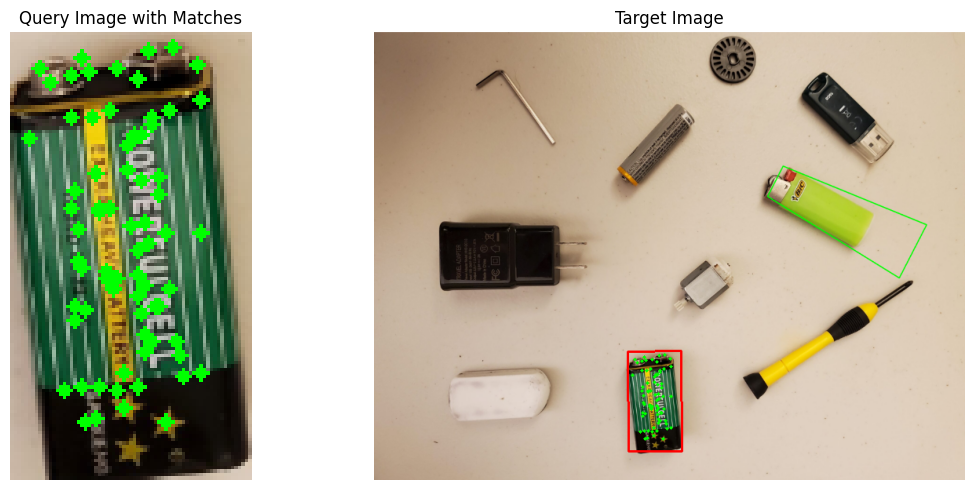

In [53]:
# Run detection
query_result, target_result, num_inliers = detect_object(query_img, target_img)

# Display results side by side without axes
plt.figure(figsize=(12, 5))

# Query image
plt.subplot(121)
plt.imshow(cv2.cvtColor(query_result, cv2.COLOR_BGR2RGB))
plt.title('Query Image with Matches')
plt.axis('off')  # Turn off the axes

# Target image
plt.subplot(122)
plt.imshow(cv2.cvtColor(target_result, cv2.COLOR_BGR2RGB))
plt.title(f'Target Image')
plt.axis('off')  # Turn off the axes

plt.tight_layout()  # Adjust the spacing between images
plt.show()

**Explanation:**  
In this final step, we run the `detect_object` function to find the query object in the target image. The results are displayed using `matplotlib`, showing both the query and target images with the detected matches and any drawn bounding boxes. The images are displayed side by side.